In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from tqdm import tqdm
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_transforms = A.Compose([
    A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    #A.ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.1, rotate_limit = 15,p=0.4),
    #A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True,p=0.5),
    A.RandomCrop(height=32, width=32, always_apply=True,p=0.5,),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5),
    ToTensorV2()
])

#Test Phase transformations
test_transforms = A.Compose([

                             A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
                             ToTensorV2()
                                       ])



In [3]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

train_data = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_data = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [6]:
# Model Summary
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 34, 34]           1,728
       BatchNorm2d-2           [-1, 64, 34, 34]             128
            Conv2d-3           [-1, 64, 34, 34]          36,864
       BatchNorm2d-4           [-1, 64, 34, 34]             128
            Conv2d-5           [-1, 64, 34, 34]          36,864
       BatchNorm2d-6           [-1, 64, 34, 34]             128
        BasicBlock-7           [-1, 64, 34, 34]               0
            Conv2d-8           [-1, 64, 34, 34]          36,864
       BatchNorm2d-9           [-1, 64, 34, 34]             128
           Conv2d-10           [-1, 64, 34, 34]          36,864
      BatchNorm2d-11           [-1, 64, 34, 34]             128
       BasicBlock-12           [-1, 64, 34, 34]               0
           Conv2d-13          [-1, 128, 17, 17]          73,728
      BatchNorm2d-14          [-1,

In [7]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.41E-02


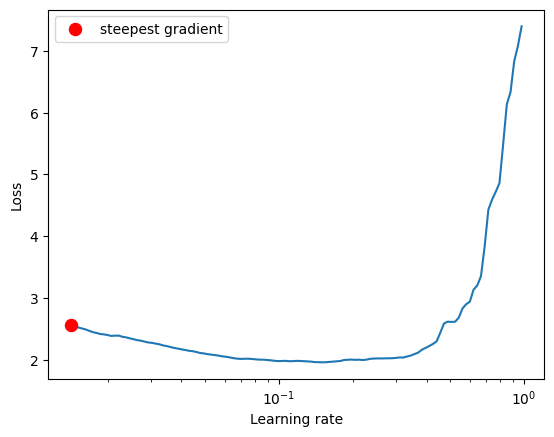

In [8]:
! pip install torch_lr_finder
from torch_lr_finder import LRFinder

model = ResNet18().to(device)
optimizer=optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
Lr_Finder=LRFinder(model,optimizer,criterion,device='cuda')
Lr_Finder.range_test(train_loader,end_lr=10,num_iter=200,step_mode='exp')
Lr_Finder.plot()
Lr_Finder.reset()

In [9]:
from torch.optim.lr_scheduler import OneCycleLR
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
EPOCHS = 20

scheduler = OneCycleLR(optimizer,
                       max_lr=1.80E-02,
                       steps_per_epoch=len(train_loader),
                       epochs=EPOCHS,
                       pct_start=5/EPOCHS,
                       div_factor=100,
                       three_phase=False,
                       final_div_factor=100,
                       anneal_strategy='linear')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 0


Train: Loss=1.1508 Batch_id=97 Accuracy=44.87: 100%|██████████| 98/98 [01:14<00:00,  1.31it/s]


Test set: Average loss: 1.1951, Accuracy: 5640/10000 (56.40%)

EPOCH: 1


Train: Loss=0.9893 Batch_id=97 Accuracy=59.82: 100%|██████████| 98/98 [01:12<00:00,  1.36it/s]


Test set: Average loss: 1.0522, Accuracy: 6151/10000 (61.51%)

EPOCH: 2


Train: Loss=0.8787 Batch_id=97 Accuracy=67.44: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 1.0072, Accuracy: 6650/10000 (66.50%)

EPOCH: 3


Train: Loss=0.7132 Batch_id=97 Accuracy=72.64: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.7361, Accuracy: 7445/10000 (74.45%)

EPOCH: 4


Train: Loss=0.6314 Batch_id=97 Accuracy=76.35: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.8556, Accuracy: 7220/10000 (72.20%)

EPOCH: 5


Train: Loss=0.6339 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [01:11<00:00,  1.37it/s]


Test set: Average loss: 0.6621, Accuracy: 7808/10000 (78.08%)

EPOCH: 6


Train: Loss=0.5892 Batch_id=97 Accuracy=81.26: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.7119, Accuracy: 7599/10000 (75.99%)

EPOCH: 7


Train: Loss=0.5530 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.6432, Accuracy: 7897/10000 (78.97%)

EPOCH: 8


Train: Loss=0.5154 Batch_id=97 Accuracy=84.26: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.6928, Accuracy: 7704/10000 (77.04%)

EPOCH: 9


Train: Loss=0.4425 Batch_id=97 Accuracy=85.20: 100%|██████████| 98/98 [01:11<00:00,  1.37it/s]


Test set: Average loss: 0.6410, Accuracy: 7933/10000 (79.33%)

EPOCH: 10


Train: Loss=0.4124 Batch_id=97 Accuracy=86.28: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.4995, Accuracy: 8354/10000 (83.54%)

EPOCH: 11


Train: Loss=0.3850 Batch_id=97 Accuracy=87.51: 100%|██████████| 98/98 [01:11<00:00,  1.37it/s]


Test set: Average loss: 0.5382, Accuracy: 8265/10000 (82.65%)

EPOCH: 12


Train: Loss=0.3125 Batch_id=97 Accuracy=88.45: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.5728, Accuracy: 8166/10000 (81.66%)

EPOCH: 13


Train: Loss=0.2899 Batch_id=97 Accuracy=88.93: 100%|██████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.5072, Accuracy: 8391/10000 (83.91%)

EPOCH: 14


Train: Loss=0.3523 Batch_id=97 Accuracy=89.46: 100%|██████████| 98/98 [01:10<00:00,  1.39it/s]


Test set: Average loss: 0.5648, Accuracy: 8191/10000 (81.91%)

EPOCH: 15


Train: Loss=0.2104 Batch_id=97 Accuracy=90.27: 100%|██████████| 98/98 [01:10<00:00,  1.38it/s]


Test set: Average loss: 0.6171, Accuracy: 8179/10000 (81.79%)

EPOCH: 16


Train: Loss=0.2993 Batch_id=97 Accuracy=90.89: 100%|██████████| 98/98 [01:10<00:00,  1.39it/s]


Test set: Average loss: 0.6000, Accuracy: 8129/10000 (81.29%)

EPOCH: 17


Train: Loss=0.1854 Batch_id=97 Accuracy=91.38: 100%|██████████| 98/98 [01:10<00:00,  1.38it/s]


Test set: Average loss: 0.6967, Accuracy: 8079/10000 (80.79%)

EPOCH: 18


Train: Loss=0.2977 Batch_id=97 Accuracy=92.09: 100%|██████████| 98/98 [01:10<00:00,  1.38it/s]


Test set: Average loss: 0.5986, Accuracy: 8316/10000 (83.16%)

EPOCH: 19


Train: Loss=0.1961 Batch_id=97 Accuracy=92.23: 100%|██████████| 98/98 [01:10<00:00,  1.38it/s]


Test set: Average loss: 0.5371, Accuracy: 8421/10000 (84.21%)



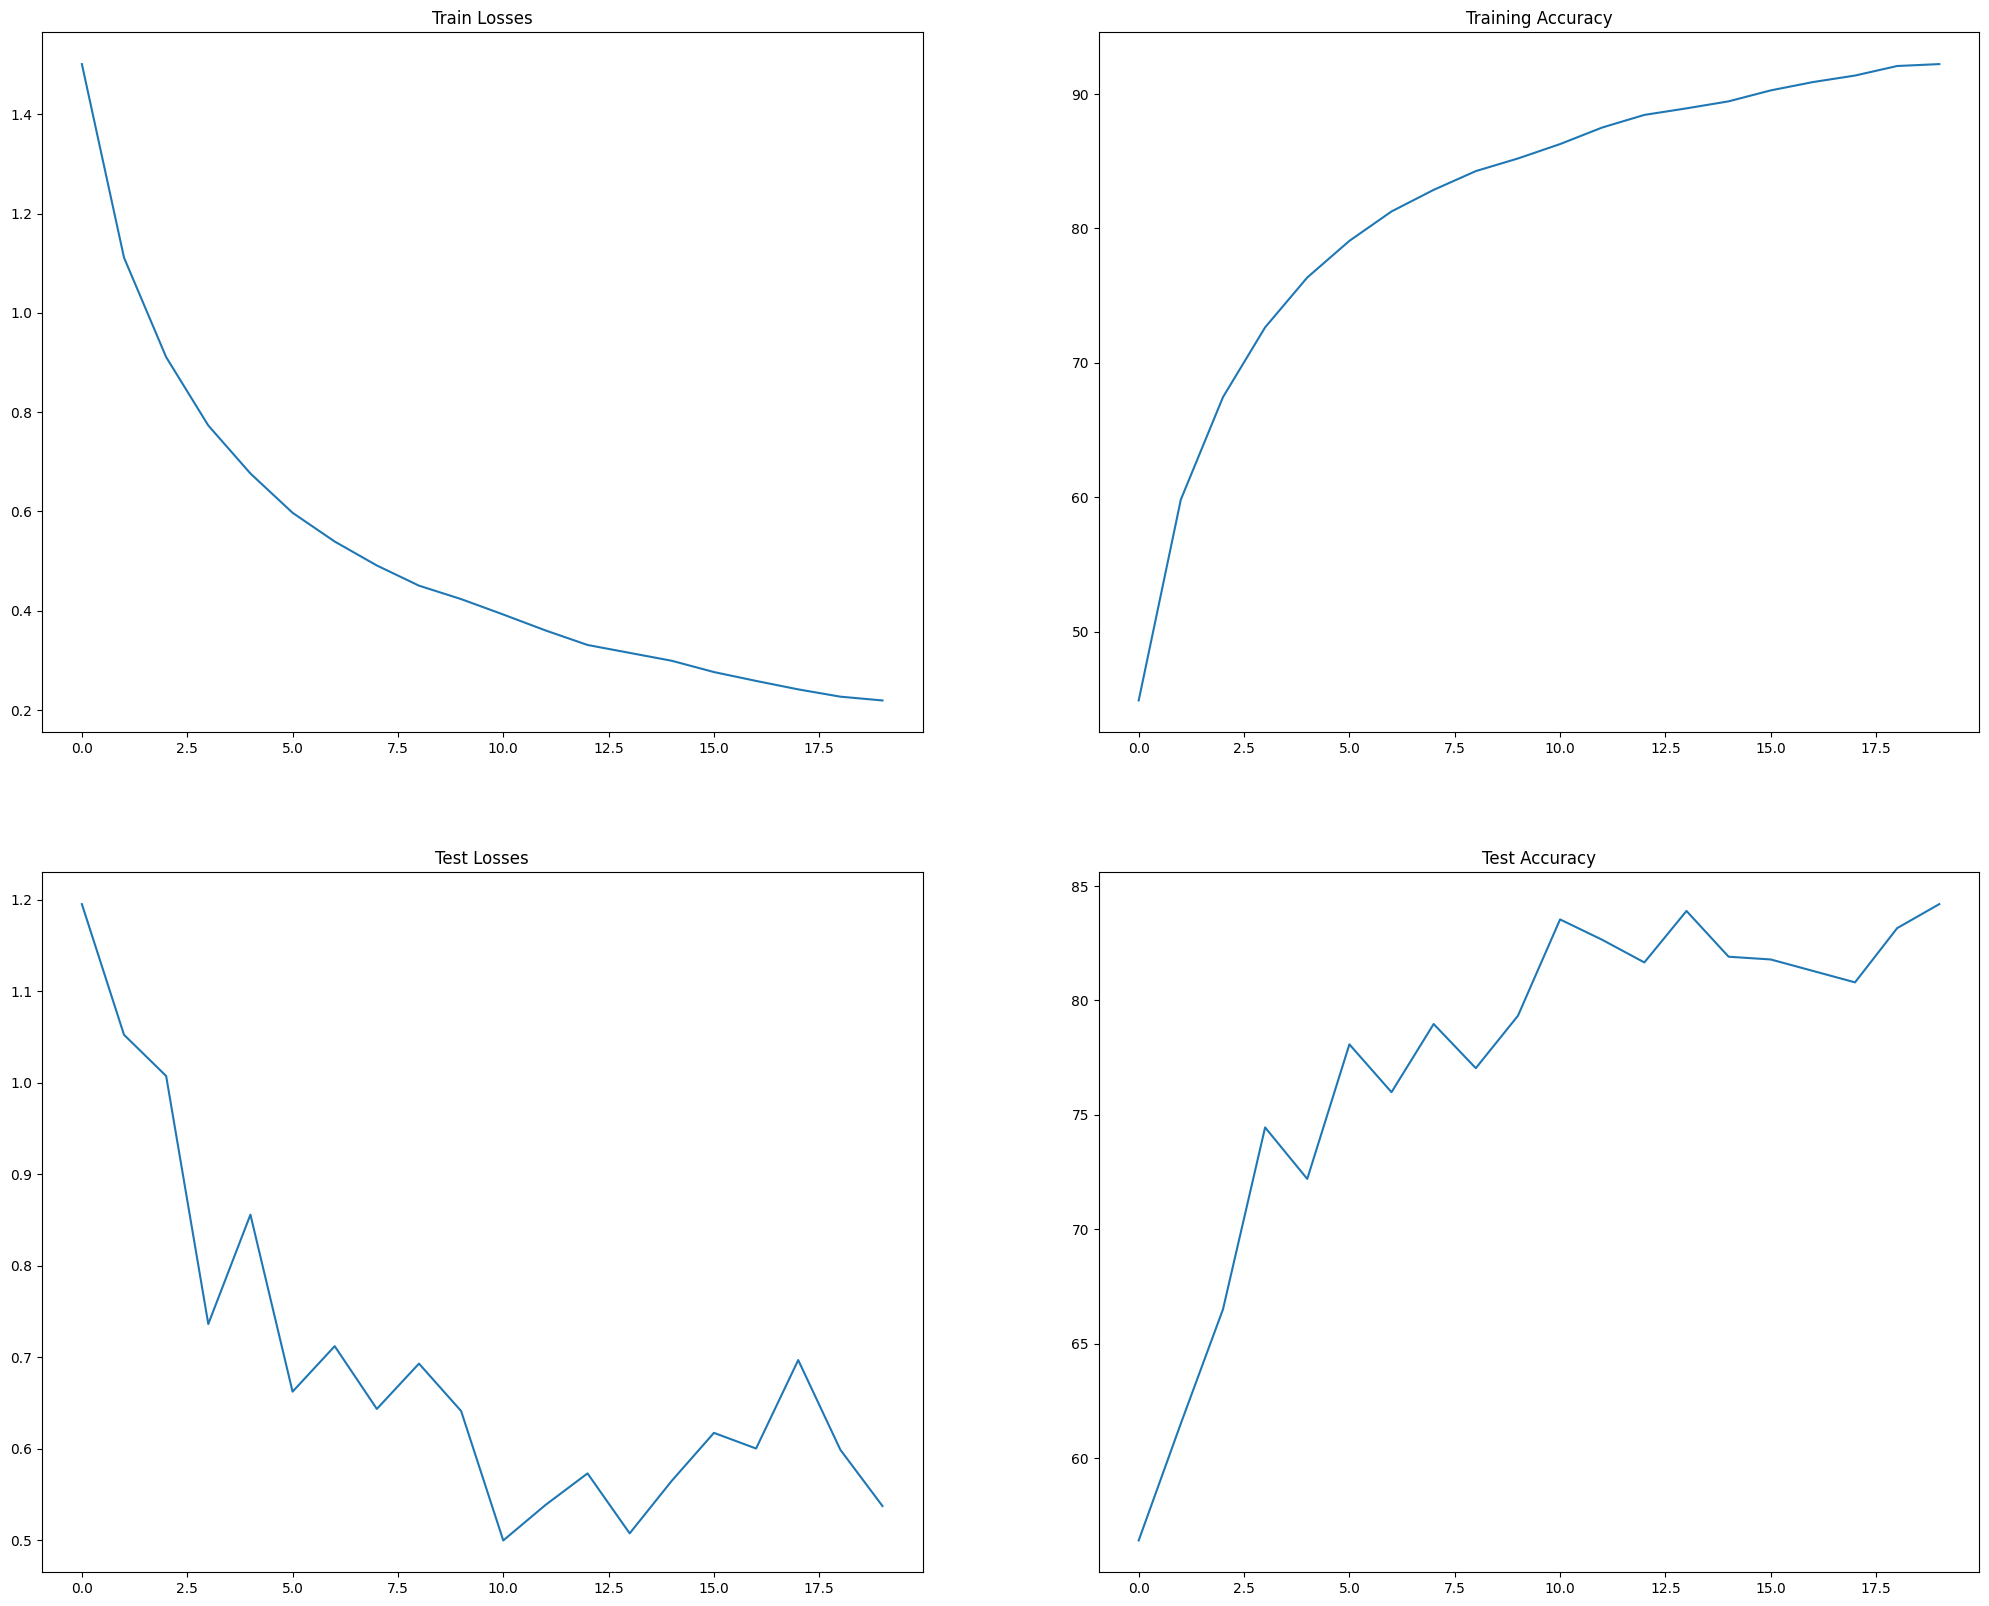

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)


In [12]:
# Wrong predictions
cnt=0
import random
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
img_lst=[]
img_tensor=[]
cat_lst=[]
x_lst=[]
for i in range(0,127):
  x = random.randint(0,127)

  if pred[x].item()!=target[x].item():
    img1=data[x]
    img=data[x].permute(1, 2, 0).cpu().numpy()
    img_lst.append(img)
    img_tensor.append(img1)
    cat=[value for key,value in enumerate(train_data.class_to_idx) if key==target[x].item()][0]
    cat_lst.append(cat)
    x_lst.append(x)
    cnt+=1
  if cnt>9:
    break

In [13]:
import random

def misclassified_image(test_loader,device,model,train_data):

  cnt=0
  data, target = next(iter(test_loader))
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = output.argmax(dim=1, keepdim=True)
  img_lst=[]
  img_tensor=[]
  cat_lst=[]
  x_lst=[]
  for i in range(0,127):
    x = random.randint(0,127)

    if pred[x].item()!=target[x].item():
      img1=data[x]
      img=data[x].permute(1, 2, 0).cpu().numpy()
      img_lst.append(img)
      img_tensor.append(img1)
      cat=[value for key,value in enumerate(train_data.class_to_idx) if key==target[x].item()][0]
      cat_lst.append(cat)
      x_lst.append(x)
      cnt+=1
    if cnt>9:
      break
  return img_lst,img_tensor,cat_lst

In [ ]:
img_tensor[0].shape

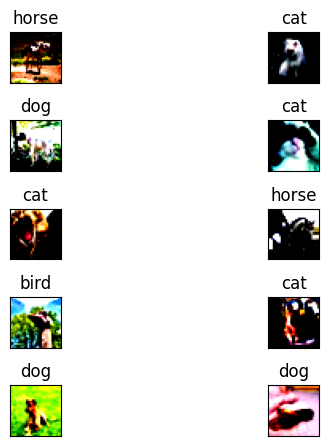

In [14]:
for i in range(10):
  plt.subplot(5,2,i+1)
  plt.tight_layout()
  plt.imshow(img_lst[i])
  plt.title(cat_lst[i])
  plt.xticks([])
  plt.yticks([])

In [15]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=c3ccc5cfcd7fd20d61c764208b475b933256718483ec8477bddfa5deaf0a4de8
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
img,label=next(iter(test_loader))
img_new=img[0]
img_new_gpu=img_new.to(device)
img_new_gpu=img_new_gpu.unsqueeze(0)
#img_new.resize(-1,3,32,32)

In [ ]:
plt.imshow(img_new.permute(1, 2, 0))
#plt.imshow(img_new)
plt.show()

In [16]:
target_layers = [model.layer4[-1]]
placeholder=torch.zeros(size=(3,3,32,32))
input_tensor=placeholder.cuda()
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0,:]

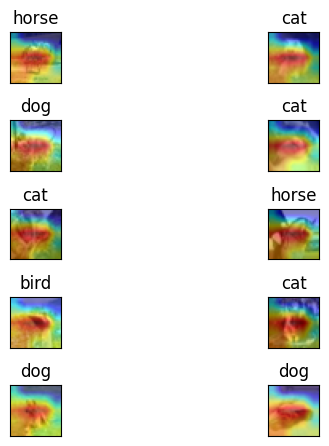

In [17]:
import matplotlib.pyplot as plt
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                                transforms.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
#mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
for i in range(10):
  img_req=img_tensor[i].to(device)
  inv_tensor = invTrans(img_req)
  inv_tensor_1=inv_tensor.cpu().permute(1, 2, 0).numpy()
  visualization = show_cam_on_image(inv_tensor_1,grayscale_cam, use_rgb=True)
  plt.subplot(5,2,i+1)
  plt.tight_layout()
  plt.imshow(visualization)
  plt.title(cat_lst[i])
  plt.xticks([])
  plt.yticks([])
#inv_tensor = invTrans(img_new_gpu)